## Dependencies

In [1]:
import json, warnings, shutil, glob
from jigsaw_utility_scripts import *
from scripts_step_lr_schedulers import *
from transformers import TFXLMRobertaModel, XLMRobertaConfig
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [2]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [3]:
database_base_path = '/kaggle/input/jigsaw-data-split-roberta-128-ratio-2/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", 
                       usecols=['comment_text', 'toxic', 'lang'])

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print('Validation samples: %d' % len(valid_df))
display(valid_df.head())

base_data_path = 'fold_1/'
# Unzip files
!tar -xvf /kaggle/input/jigsaw-data-split-roberta-128-ratio-2/fold_1.tar.gz

Train samples: 398350


,comment_text,toxic,toxic_int,length,word_count,token_count,fold_1,fold_2,fold_3,fold_4,fold_5
0,If someone's 'short-circuiting' mentally speak...,0.0,0,588,97,148,train,validation,train,train,train
1,Oh Willy!! You took his bait! Ignore trolls li...,1.0,1,54,10,19,validation,train,train,train,train
2,"What are you talking about, and why do you hav...",0.0,0,177,34,40,train,validation,train,train,train
3,"Ohh, and Pennsylvania is down .% since in term...",0.0,0,155,26,35,train,train,train,validation,train
4,The consumer will end up paying more if this c...,0.0,0,341,62,71,validation,train,train,train,train


Validation samples: 8000


,comment_text,lang,toxic
0,Este usuario ni siquiera llega al rango de ...,es,0
1,Il testo di questa voce pare esser scopiazzato...,it,0
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


fold_1/
fold_1/x_train.npy
fold_1/y_train.npy
fold_1/y_valid.npy
fold_1/x_train_tail.npy
fold_1/y_train_int.npy
fold_1/y_valid_int.npy
fold_1/x_valid.npy
fold_1/x_valid_tail.npy


# Model parameters

In [4]:
base_path = '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/'

config = {
  "MAX_LEN": 128,
  "BATCH_SIZE": 128,
  "EPOCHS": 4,
  "LEARNING_RATE": 1e-5, 
  "ES_PATIENCE": None,
  "base_model_path": base_path + 'tf-xlm-roberta-large-tf_model.h5',
  "config_path": base_path + 'xlm-roberta-large-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

## Learning rate schedule

Learning rate schedule: 1e-07 to 9.96e-06 to 1.16e-07


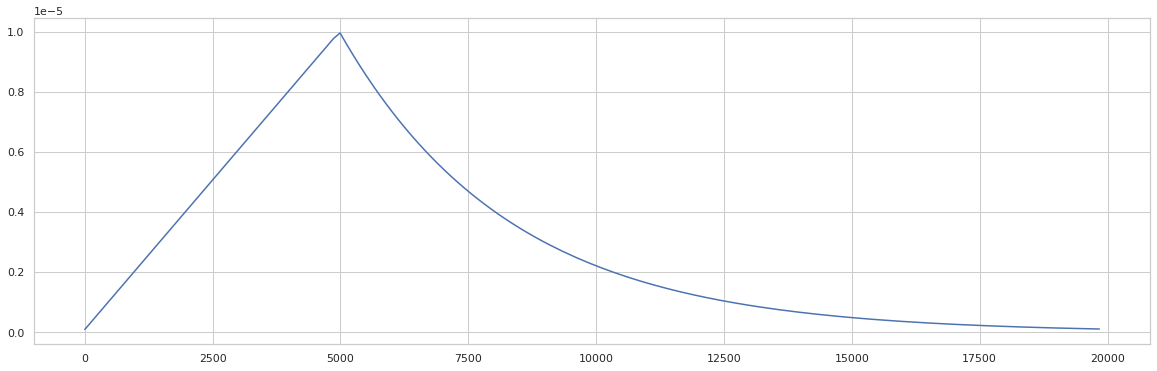

In [5]:
lr_min = 1e-7
lr_start = 1e-7
lr_max = config['LEARNING_RATE']
step_size = len(k_fold[k_fold['fold_1'] == 'train']) // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size * 2 # tail
hold_max_steps = 0
warmup_steps = step_size * 1 * 2 # tail
decay = .9997

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps, hold_max_steps, 
                                      lr_start, lr_max, lr_min, decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [6]:
module_config = XLMRobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFXLMRobertaModel.from_pretrained(config['base_model_path'], config=module_config)
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    cls_token = last_hidden_state[:, 0, :]
    
    output = layers.Dense(1, activation='sigmoid', name='output')(cls_token)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    
    return model

# Train

In [7]:
# Load data
x_train = np.load(base_data_path + 'x_train.npy')
y_train = np.load(base_data_path + 'y_train.npy').reshape(x_train.shape[1], 1).astype(np.float32)
x_valid_ml = np.load(database_base_path + 'x_valid.npy')
y_valid_ml = np.load(database_base_path + 'y_valid.npy').reshape(x_valid_ml.shape[1], 1).astype(np.float32)

#################### ADD TAIL ####################
x_train = np.hstack([x_train, np.load(base_data_path + 'x_train_tail.npy')])
y_train = np.vstack([y_train, y_train])

step_size = x_train.shape[1] // config['BATCH_SIZE']
valid_step_size = x_valid_ml.shape[1] // config['BATCH_SIZE']

# Build TF datasets
train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
train_data_iter = iter(train_dist_ds)
valid_data_iter = iter(valid_dist_ds)

# Step functions
@tf.function
def train_step(data_iter):
    def train_step_fn(x, y):
        with tf.GradientTape() as tape:
            probabilities = model(x, training=True)
            loss = loss_fn(y, probabilities)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_auc.update_state(y, probabilities)
        train_loss.update_state(loss)
    for _ in tf.range(step_size):
        strategy.experimental_run_v2(train_step_fn, next(data_iter))

@tf.function
def valid_step(data_iter):
    def valid_step_fn(x, y):
        probabilities = model(x, training=False)
        loss = loss_fn(y, probabilities)
        valid_auc.update_state(y, probabilities)
        valid_loss.update_state(loss)
    for _ in tf.range(valid_step_size):
        strategy.experimental_run_v2(valid_step_fn, next(data_iter))

# Train model
with strategy.scope():
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: 
                                exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                 warmup_steps, hold_max_steps, lr_start, 
                                                                 lr_max, lr_min, decay))
    loss_fn = losses.binary_crossentropy
    train_auc = metrics.AUC()
    valid_auc = metrics.AUC()
    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()

metrics_dict = {'loss': train_loss, 'auc': train_auc, 
                'val_loss': valid_loss, 'val_auc': valid_auc}

history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                     step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], 
                     config['ES_PATIENCE'], save_last=False)
# model.save_weights('model.h5')

# Make predictions
x_train = np.load(base_data_path + 'x_train.npy')
x_valid = np.load(base_data_path + 'x_valid.npy')
x_valid_ml_eval = np.load(database_base_path + 'x_valid.npy')

train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE'], AUTO))
valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE'], AUTO))
valid_ml_preds = model.predict(get_test_dataset(x_valid_ml_eval, config['BATCH_SIZE'], AUTO))

k_fold.loc[k_fold['fold_1'] == 'train', 'pred_1'] = np.round(train_preds)
k_fold.loc[k_fold['fold_1'] == 'validation', 'pred_1'] = np.round(valid_preds)
valid_df['pred_1'] = valid_ml_preds


# Fine-tune on validation set
x_train_ml_tail = x_valid_ml.copy()
y_train_ml_tail = y_valid_ml.copy()
#################### ADD TAIL ####################
x_train_ml_tail = np.hstack([x_train_ml_tail, np.load(database_base_path + 'x_valid_tail.npy')])
y_train_ml_tail = np.vstack([y_train_ml_tail, y_train_ml_tail])

valid_step_size_tail = x_train_ml_tail.shape[1] // config['BATCH_SIZE']

# Build TF datasets
train_ml_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train_ml_tail, y_train_ml_tail, 
                                                                                 config['BATCH_SIZE'], AUTO, seed=SEED))
train_ml_data_iter = iter(train_ml_dist_ds)

history_ml = custom_fit(model, metrics_dict, train_step, valid_step, train_ml_data_iter, valid_data_iter, 
                        valid_step_size_tail, valid_step_size, config['BATCH_SIZE'], 1, 
                        config['ES_PATIENCE'], save_last=False)
model.save_weights('model_ml.h5')

# Make predictions
valid_ml_preds = model.predict(get_test_dataset(x_valid_ml_eval, config['BATCH_SIZE'], AUTO))
valid_df['pred_ml_1'] = valid_ml_preds

### Delete data dir
shutil.rmtree(base_data_path)

Train for 4979 steps, validate for 62 steps

EPOCH 1/4
time: 1198.5s loss: 0.3713 auc: 0.9135 val_loss: 0.2434 val_auc: 0.9229

EPOCH 2/4
time: 1005.7s loss: 0.3252 auc: 0.9435 val_loss: 0.2639 val_auc: 0.9145

EPOCH 3/4
time: 1005.7s loss: 0.3128 auc: 0.9508 val_loss: 0.2788 val_auc: 0.9179

EPOCH 4/4
time: 1005.9s loss: 0.3090 auc: 0.9530 val_loss: 0.2915 val_auc: 0.9098
Training finished
Train for 125 steps, validate for 62 steps

EPOCH 1/1
time: 1109.3s loss: 7.2714 auc: 0.9568 val_loss: 0.1256 val_auc: 0.9805
Training finished


## Model loss graph

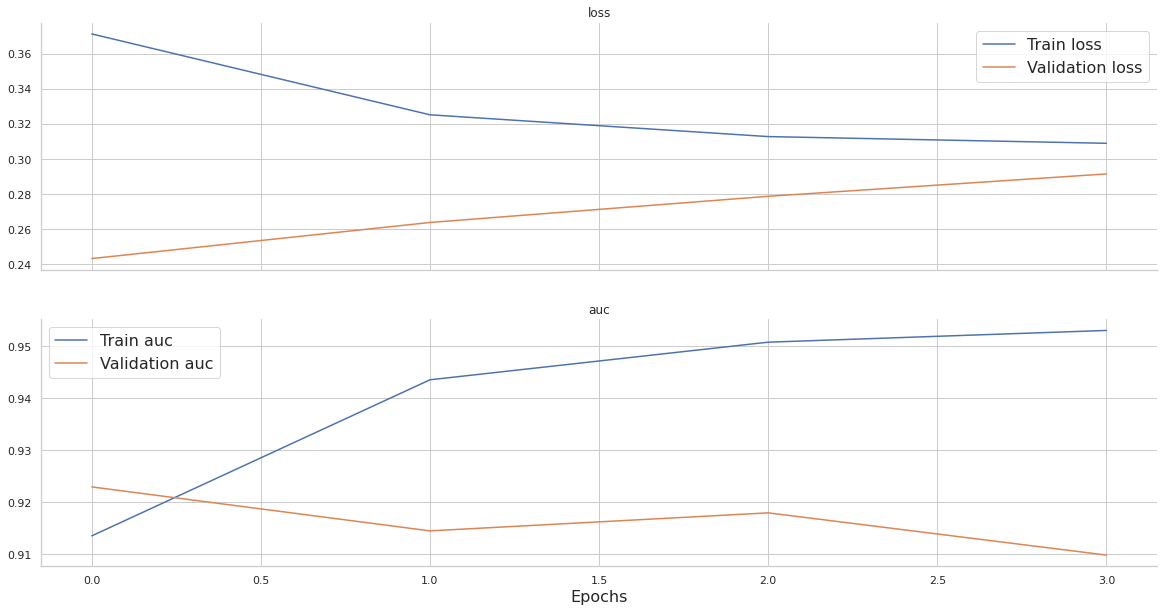

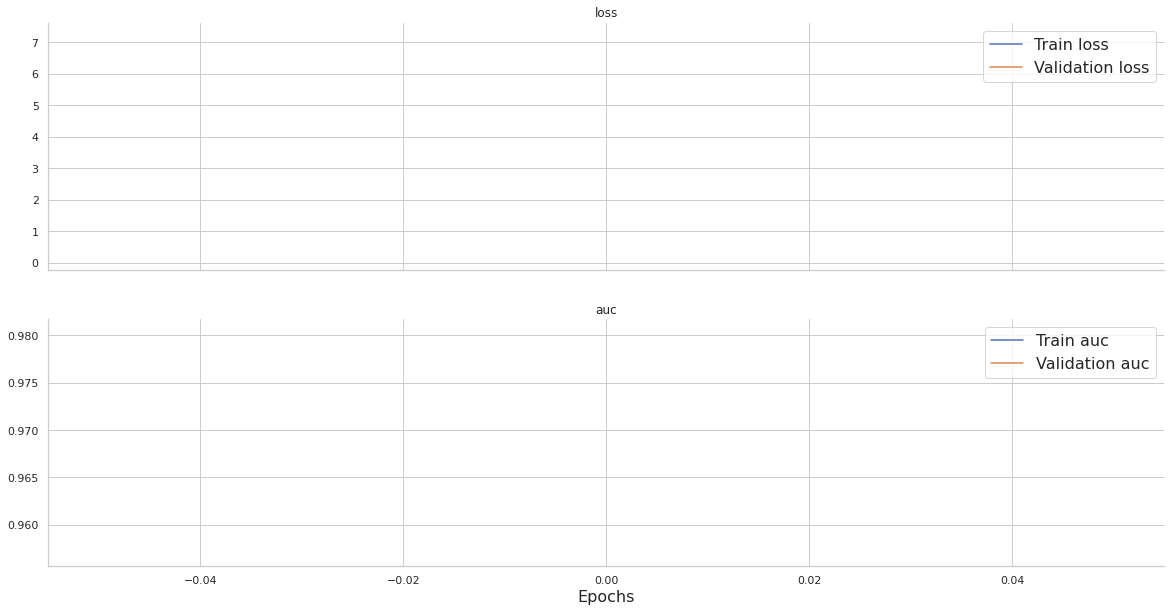

In [8]:
plot_metrics(history)
# ML fine-tunned preds
plot_metrics(history_ml)

# Model evaluation

In [9]:
display(evaluate_model(k_fold, 1, label_col='toxic_int').style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1
Metric,,,,,
ROC AUC,0.939122,0.917215,0.0219069,0.939122,0.917215
Accuracy,0.938073,0.919104,0.0189689,0.938073,0.919104
Precision,0.880592,0.85559,0.025002,0.880592,0.85559
Recall,0.942279,0.911531,0.0307481,0.942279,0.911531
F1-score,0.910392,0.882675,0.0277167,0.910392,0.882675
Support,106392,26597,79795,106392,26597


# Confusion matrix

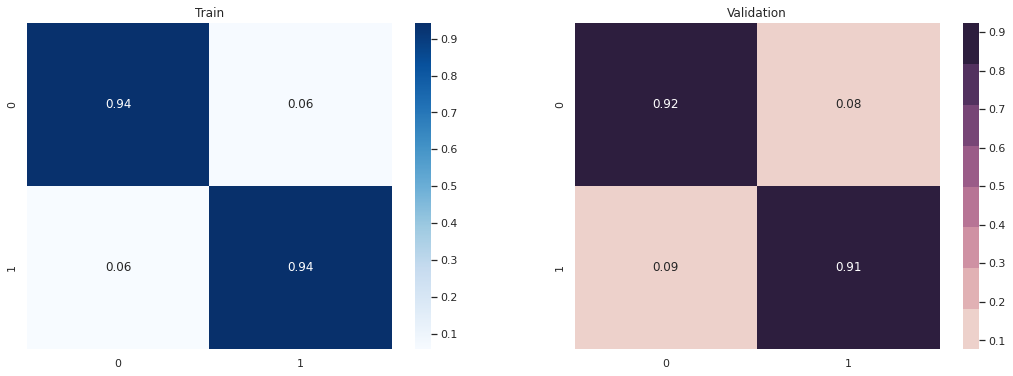

In [10]:
train_set = k_fold[k_fold['fold_1'] == 'train']
validation_set = k_fold[k_fold['fold_1'] == 'validation'] 
plot_confusion_matrix(train_set['toxic_int'], train_set['pred_1'], 
                      validation_set['toxic_int'], validation_set['pred_1'])

# Model evaluation by language

In [11]:
display(evaluate_model_lang(valid_df, 1).style.applymap(color_map))
# ML fine-tunned preds
display(evaluate_model_lang(valid_df, 1, pred_col='pred_ml').style.applymap(color_map))

,Mean,Fold_1
Lang / ROC AUC,,
Overall,0.918036,0.918036
es,0.895584,0.895584
it,0.881443,0.881443
tr,0.982915,0.982915


,Mean,Fold_1
Lang / ROC AUC,,
Overall,0.981596,0.981596
es,0.969961,0.969961
it,0.971673,0.971673
tr,0.995877,0.995877


# Visualize predictions

In [12]:
pd.set_option('max_colwidth', 120)
print('English validation set')
display(k_fold[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(10))

print('Multilingual validation set')
display(valid_df[['comment_text', 'toxic'] + [c for c in valid_df.columns if c.startswith('pred')]].head(10))

English validation set


,comment_text,toxic,pred_1
0,If someone's 'short-circuiting' mentally speaking they do uncharacteristic things. I witnessed this with my Uncle Ro...,0.000000,0.0
1,Oh Willy!! You took his bait! Ignore trolls like that.,1.000000,1.0
2,"What are you talking about, and why do you have to do it anonymously? Do you have any source for your claim that uni...",0.000000,0.0
3,"Ohh, and Pennsylvania is down .% since in terms of manufacturing jobs, their losses have been much more gradual but ...",0.000000,0.0
4,The consumer will end up paying more if this corporate tax passes. What will the State do with the money ? Waste the...,0.000000,0.0
5,There aren't many places left where the social system isn't under some kind of assault. Europe as we know it is on t...,0.000000,0.0
6,"Sadly, I think that your described quite succinctly the state of mind of a tradition that applies to many and consti...",0.000000,0.0
7,Everything McAleer touches stinks.,0.718750,1.0
8,Now lets waste thousands in taxpayer money for the Oregon Stupid Police to investigate a F%*$ing rock.,0.757143,1.0
9,"Nonsense, this is not apposition. This is apposition: Make America, an industrialized country, a world leader again....",0.166667,0.0


Multilingual validation set


,comment_text,toxic,pred_1,pred_ml_1
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purifi...,0,0.755212,0.292791
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, ...",0,0.000401,0.003044
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nive...",1,0.756203,0.900089
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siy...,0,0.000184,0.000100
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecek...,0,0.000334,0.000682
5,"güzel, zaten kaynaklandırması zor subjektif kategoriler bunlar. bazı maddelerden çıkartmak, kiminden çıkartıp kimind...",0,0.001258,0.005020
6,"No es mala idea. De hecho, yo estaba pensando descolgarme ya del reto mensual, pero esto vuelve a ilusionarme. El pr...",0,0.000917,0.000348
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık çok teşekkürler.Önceki sürümleri araştırdım.13 Haziran 2010 da Kullanıc...",0,0.000103,0.000165
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umarım her şey istediğin gibidir. Bu arada Janet Jackson maddesi seçkin ma...,0,0.000582,0.000365
9,"Creo que es importante que podamos reconocer a gente como Victor Manuel Vucetich , quien es originario de Tampico y ...",0,0.002666,0.000905


# Test set predictions

In [13]:
x_test = np.load(database_base_path + 'x_test.npy')
test_preds = model.predict(get_test_dataset(x_test, config['BATCH_SIZE'], AUTO))

In [14]:
submission = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
submission['toxic'] = test_preds
submission.to_csv('submission.csv', index=False)

display(submission.describe())
display(submission.head(10))

,id,toxic
count,63812.000000,6.381200e+04
mean,31905.500000,2.244632e-01
std,18421.082026,3.351159e-01
min,0.000000,2.980232e-08
25%,15952.750000,2.805591e-04
50%,31905.500000,9.049803e-03
75%,47858.250000,3.834096e-01
max,63811.000000,9.999938e-01


,id,toxic
0,0,0.000020
1,1,0.001478
2,2,0.294744
3,3,0.002064
4,4,0.000673
5,5,0.011144
6,6,0.000016
7,7,0.000808
8,8,0.026618
9,9,0.231452
